In [1]:
import pandas as pd
from rdkit import Chem
import seaborn as sns
from tqdm import tqdm
import numpy as np

In [2]:
tqdm.pandas()


## Novartis CYP3A4

Dataset from https://pubs.acs.org/doi/10.1021/acs.chemrestox.3c00305

**IMPORTANT** 

The so called "train set" is a based on labeling a curated public dataset from Chembl and pubchem with a surrogate model  and is **NOT ACTUALLY THE TRAINING SET USED FOR THE MODELS**

The test set appears to be real data from public compounds

## Assay Info

### Irreversible

To assess time-dependent inhibition (TDI), inactivation rate constants (kobs values) were determined. For this purpose, test articles (10 μM) were dispensed to 96-well plates, and the preincubation was started by the addition of human liver microsomes supplemented with reduced nicotinamide adenine dinucleotide phosphate (NADPH). After 0, 7, 16, and 32 min, the residual CYP3A activity was determined by the addition of midazolam (including d4-1-hydroxy-midazolam as internal standard) and incubated for six additional minutes before being stopped by the addition of acetonitrile. The supernatants were analyzed for the CYP3A4 selective metabolites 1-hydroxymidazolam and d4-1-hydroxymidazolam using liquid chromatography–mass spectrometry (LC–MS). The time-dependent CYP3A enzyme activity was calculated using the normalized AREA-ratios of 1-hydroxymidazolam to the internal standard and plotted over the preincubation time. The first-order inactivation rate constant kobs was determined by a 1-parameter fit using a range of 80% and a background of 20%. The percentage of reversible inhibition (%inh-rev) was calculated by the AREA-ratio at a preincubation time of 0 min in relation to the AREA-ratio of the control containing dimethyl sulfoxide (DMSO) only. In the case of a strong reversible inhibition (%inh-rev >50%), no kobs values were calculated.

### Reversible

Reversible inhibition was investigated using the formation rate of enzyme-specific metabolites from midazolam (CYP3A4), diclofenac (CYP2C9), and bufuralol (CYP2D6) in human liver microsomes. Substrates, internal standards, and test compounds were dispensed by acoustic dispensing to a 384-well microplate. The incubation was started by the addition of human liver microsomes supplemented with NADPH and plates that were immediately transferred to an incubator. Incubations were stopped by the addition of acetonitrile/formic acid (93:7), and the supernatant was analyzed by liquid chromatography–mass spectrometry (LC–MS) for the enzyme-specific metabolites and internal standards. The AREA-ratios of test compounds were normalized to the average AREA-ratio of DMSO (100% activity) and an inhibitor cocktail (0% activity) to determine the IC50 (test compound concentration causing an inhibition of 50%) using a dose–response model by a two-parameter-fit in which 100 and 0% activities were constrained.


### Binning for TDI

"Apart from the numerical prediction of inactivation rates of CYP3A4 TDI, three-class predictions were carried out, giving a negative (inactivation rate kobs < 0.01 min–1), weak positive (0.01 ≤ kobs ≤ 0.025 min–1), or positive (kobs > 0.025 min–1) output"


In [3]:
test = pd.read_csv("./CYP3A4_novartis_raw/test.csv")


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Structure             368 non-null    object 
 1   kobs                  368 non-null    float64
 2   Non-proprietary name  368 non-null    object 
dtypes: float64(1), object(2)
memory usage: 8.8+ KB


In [5]:
train = pd.read_csv("./CYP3A4_novartis_raw/train.csv", index_col=False)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16373 entries, 0 to 16372
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            16373 non-null  int64  
 1   Structure             16372 non-null  object 
 2   log_kobs              16373 non-null  float64
 3   pIC50_CYP3A4          16373 non-null  float64
 4   pIC50_CYP2C9          16373 non-null  float64
 5   pIC50_CYP2D6          16373 non-null  float64
 6   log_kobs_model_0      16373 non-null  float64
 7   log_kobs_model_1      16373 non-null  float64
 8   log_kobs_model_2      16373 non-null  float64
 9   log_kobs_model_3      16373 non-null  float64
 10  log_kobs_model_4      16373 non-null  float64
 11  log_kobs_model_5      16373 non-null  float64
 12  log_kobs_model_6      16373 non-null  float64
 13  log_kobs_model_7      16373 non-null  float64
 14  log_kobs_model_8      16373 non-null  float64
 15  log_kobs_model_9   

In [7]:
train.Source.value_counts()

Source
PubChem AID 410    8360
ChEMBL             5750
PubChem AID 884    2263
Name: count, dtype: int64

In [8]:
test.head()

,Structure,kobs,Non-proprietary name
0,CCN(CC)CCNC(=O)c1ccc(cc1)NC(C)=O,0.005,Acecainide
1,COc1ccc2c(c1)C(CC(=O)OCC(O)=O)=C(C)N2C(=O)c3cc...,0.011,Acemetacin
2,CCCSc2ccc1NC(NC(=O)OC)=Nc1c2,0.008,Albendazole
3,CC(CN(C)C)CN3c1ccccc1Sc2ccccc23,0.009,Alimemazine
4,CC3=NN=C4CN=C(c1ccccc1)c2cc(Cl)ccc2N34,0.016,Alprazolam


In [9]:
# log transform test to match train

test["log_kobs"] = np.log10(test["kobs"])

In [10]:
train.head()

,Unnamed: 0,Structure,log_kobs,pIC50_CYP3A4,pIC50_CYP2C9,pIC50_CYP2D6,log_kobs_model_0,log_kobs_model_1,log_kobs_model_2,log_kobs_model_3,...,pIC50_CYP2D6_model_1,pIC50_CYP2D6_model_2,pIC50_CYP2D6_model_3,pIC50_CYP2D6_model_4,pIC50_CYP2D6_model_5,pIC50_CYP2D6_model_6,pIC50_CYP2D6_model_7,pIC50_CYP2D6_model_8,pIC50_CYP2D6_model_9,Source
0,0,CCCCc1nc2cc(/C=C/C(=O)NO)ccc2n1CCN(CC)CC.Cl.Cl,-2.131,4.957,4.733,4.823,-2.145,-1.988,-1.912,-2.347,...,4.728,4.970,4.806,4.834,4.769,4.993,4.855,4.770,4.741,ChEMBL
1,1,CCCCc1ccc(N/C=N/O)cc1,-2.300,4.597,4.857,4.716,-2.345,-2.287,-2.399,-2.354,...,4.737,4.684,4.614,4.852,4.603,4.737,4.732,4.694,4.901,ChEMBL
2,2,C[C@H](Nc1cc(-c2sc(C3CCN(C)CC3)nc2-c2ccc(F)cc2...,-1.940,4.740,4.686,4.883,-1.935,-1.995,-1.863,-2.123,...,4.807,4.914,4.870,4.873,4.865,4.911,4.918,4.809,5.019,ChEMBL
3,3,CC(C)c1nc(-c2ccc(F)cc2)c(-c2ccc3nc(N)n(S(=O)(=...,-2.151,4.453,4.543,4.525,-2.220,-2.235,-2.149,-2.219,...,4.497,4.470,4.533,4.547,4.578,4.443,4.625,4.477,4.492,ChEMBL
4,4,CC(C)S(=O)(=O)n1c(N)nc2ccc(-c3[nH]c(C(C)(C)C)n...,-2.283,4.372,4.432,4.463,-2.379,-2.294,-2.291,-2.323,...,4.414,4.323,4.524,4.527,4.545,4.367,4.571,4.422,4.411,ChEMBL


In [11]:
train_colnames = train.columns
drop_cols = [c for c in train_colnames if "model" in c]
drop_cols.append("Unnamed: 0")

In [12]:
train_data_only = train.drop(columns=drop_cols)

In [13]:
train_data_only

,Structure,log_kobs,pIC50_CYP3A4,pIC50_CYP2C9,pIC50_CYP2D6,Source
0,CCCCc1nc2cc(/C=C/C(=O)NO)ccc2n1CCN(CC)CC.Cl.Cl,-2.131,4.957,4.733,4.823,ChEMBL
1,CCCCc1ccc(N/C=N/O)cc1,-2.300,4.597,4.857,4.716,ChEMBL
2,C[C@H](Nc1cc(-c2sc(C3CCN(C)CC3)nc2-c2ccc(F)cc2...,-1.940,4.740,4.686,4.883,ChEMBL
3,CC(C)c1nc(-c2ccc(F)cc2)c(-c2ccc3nc(N)n(S(=O)(=...,-2.151,4.453,4.543,4.525,ChEMBL
4,CC(C)S(=O)(=O)n1c(N)nc2ccc(-c3[nH]c(C(C)(C)C)n...,-2.283,4.372,4.432,4.463,ChEMBL
...,...,...,...,...,...,...
16368,c1cc2c3c(c1)ccc1cccc(c13)C2,-1.773,5.450,4.925,5.054,PubChem AID 884
16369,CC(=O)OC1CC2C(C)(C)C(O)C=C[C@@]2(C)C2CC[C@@]3(...,-1.622,5.840,4.694,4.692,PubChem AID 884
16370,COc1c(O)cc2c(-c3ccccc3)cc(=O)oc2c1OC,-1.989,4.727,5.082,4.697,PubChem AID 884
16371,CCN(CC)CCOC(=O)C(Cc1cccc2ccccc12)CC1CCCO1.O=C(...,-2.248,4.704,4.719,4.730,PubChem AID 884


In [14]:
# convert source to str
train_data_only["Source"] = train_data_only["Source"].apply(lambda x: str(x))

## EDA

Lets have a quick look at the data


`kobs` is the inactivation rate for time dependent CYP3A4 inhibition


In the paper this was further classified into negative (inactivation rate kobs < 0.01 min–1), weak positive (0.01 ≤ kobs ≤ 0.025 min–1), or positive (kobs > 0.025 min–1) output. 

<Axes: xlabel='Source', ylabel='count'>

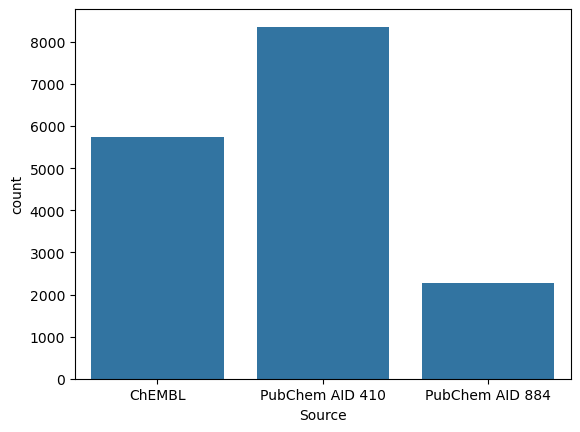

In [15]:
sns.countplot(data=train_data_only, x="Source")

<Axes: xlabel='pIC50_CYP3A4', ylabel='Count'>

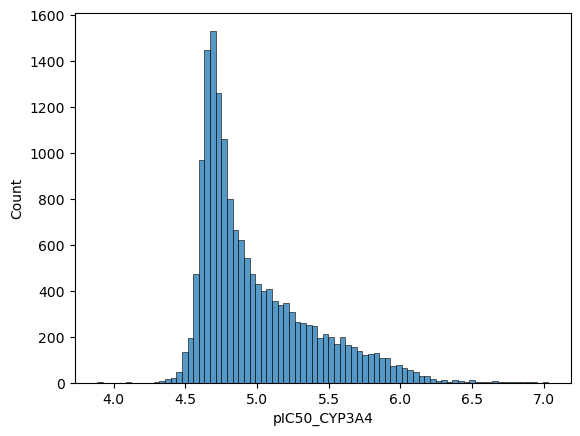

In [16]:
sns.histplot(data=train_data_only, x="pIC50_CYP3A4")


<Axes: xlabel='log_kobs', ylabel='Count'>

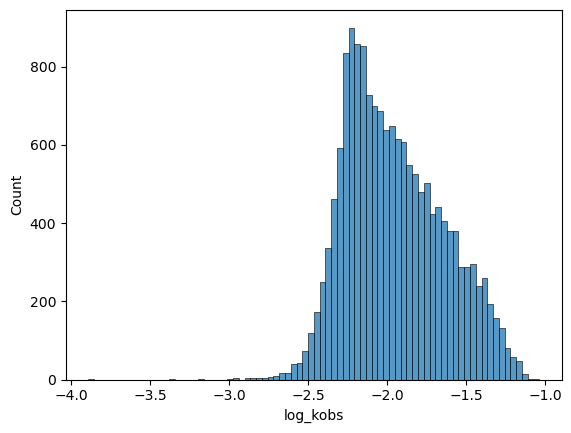

In [17]:
sns.histplot(data=train_data_only, x="log_kobs")

Seems like there is a decent dynamic range in there


Just out of interest are the different CYP pIC50s visually correlated?

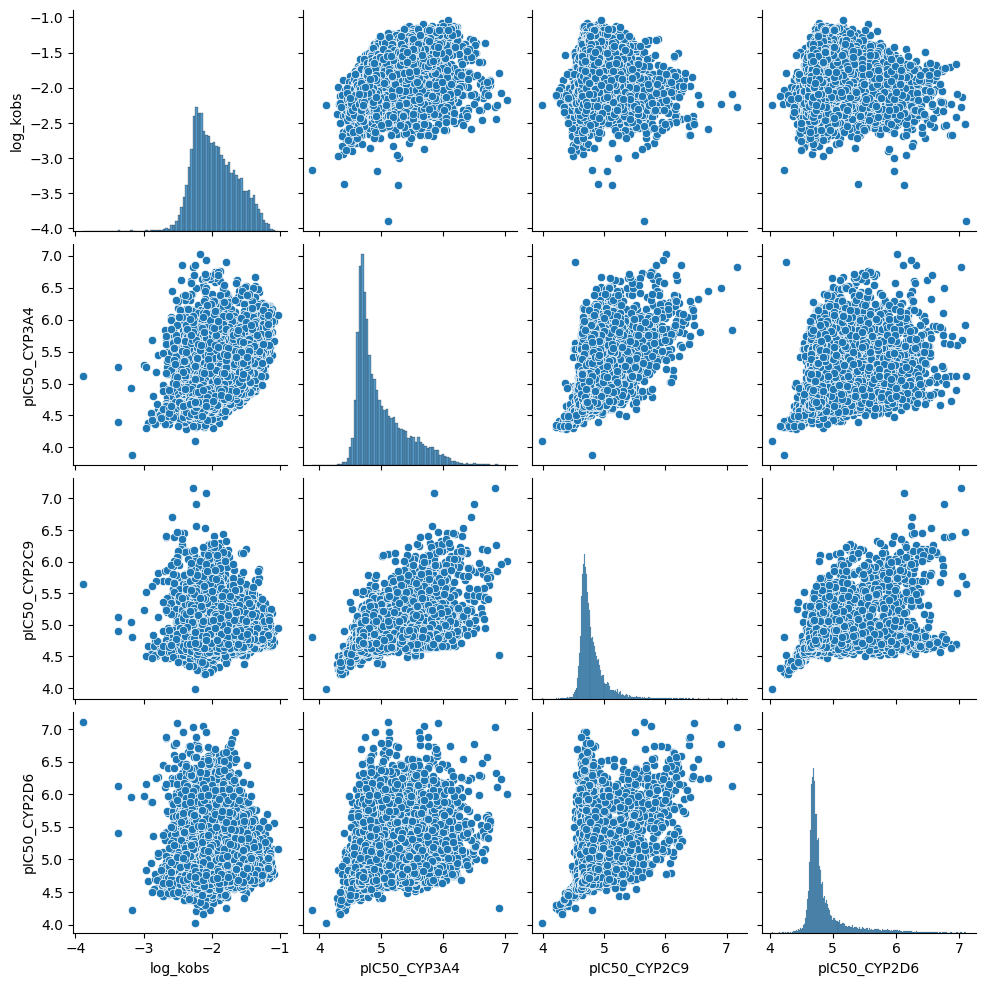

In [18]:
sns.pairplot(train_data_only);


## Canonicalise and combine

Lets canonicalise these and combine into a cleaned dataset

In [19]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.rdBase import BlockLogs
import mols2grid

In [20]:

# from Pat Walters method
def standardize_smiles(smiles):
    try:
        # follows the steps in
        # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
        # as described **excellently** (by Greg) in
        # https://www.youtube.com/watch?v=eWTApNX8dJQ
        mol = Chem.MolFromSmiles(smiles)
    
        # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
        clean_mol = rdMolStandardize.Cleanup(mol)
    
        # if many fragments, get the "parent" (the actual mol we are interested in) 
        parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
    
        # try to neutralize molecule
        uncharger = rdMolStandardize.Uncharger()  # annoying, but necessary as no convenience method exists
        uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
    
        # note that no attempt is made at reionization at this step
        # nor at ionization at some pH (rdkit has no pKa caculator)
        # the main aim to represent all molecules from different sources
        # in a (single) standard way, for use in ML, catalogue, etc.
    
        te = rdMolStandardize.TautomerEnumerator()  # idem
        taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
    
        return Chem.MolToSmiles(taut_uncharged_parent_clean_mol)
    except:
        return pd.NA

In [21]:
# train
with BlockLogs():
    train_data_only["CANONICAL_SMILES"] = train_data_only["Structure"].progress_apply(lambda x: standardize_smiles(x))
        

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16373/16373 [03:30<00:00, 77.85it/s]


In [22]:
# test
with BlockLogs():
    test["CANONICAL_SMILES"] = test["Structure"].progress_apply(lambda x: standardize_smiles(x))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 368/368 [00:02<00:00, 160.36it/s]


In [23]:
def smi_to_inchikey(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return Chem.MolToInchiKey(mol)
    except:
        return pd.NA

In [24]:
# compute inchikeys
with BlockLogs():
    train_data_only["INCHIKEY"] = train_data_only["CANONICAL_SMILES"].progress_apply(lambda x: smi_to_inchikey(x))
        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16373/16373 [00:04<00:00, 3500.06it/s]


In [25]:
with BlockLogs():
    test["INCHIKEY"] = test["CANONICAL_SMILES"].progress_apply(lambda x: smi_to_inchikey(x))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 368/368 [00:00<00:00, 4202.97it/s]


In [26]:
# join on inchikeys

In [27]:
test.INCHIKEY.isna().sum()

np.int64(0)

In [28]:
test.INCHIKEY

0      KEECCEWTUVWFCV-UHFFFAOYSA-N
1      FSQKKOOTNAMONP-UHFFFAOYSA-N
2      HXHWSAZORRCQMX-UHFFFAOYSA-N
3      ZZHLYYDVIOPZBE-UHFFFAOYSA-N
4      VREFGVBLTWBCJP-UHFFFAOYSA-N
                  ...             
363    WREGKURFCTUGRC-POYBYMJQSA-N
364    HJMQDJPMQIHLPB-UHFFFAOYSA-N
365    HBOMLICNUCNMMY-XLPZGREQSA-N
366    MWLSOWXNZPKENC-UHFFFAOYSA-N
367    GBBSUAFBMRNDJC-UHFFFAOYSA-N
Name: INCHIKEY, Length: 368, dtype: object

In [29]:
train_data_only.INCHIKEY.isna().sum()

np.int64(3)

In [30]:
train_data_only = train_data_only.dropna(subset="INCHIKEY")

In [31]:
train_data_only.INCHIKEY

0        JHDKZFFAIZKUCU-ZRDIBKRKSA-N
1        BQPCBRFOSWMALO-UHFFFAOYSA-N
2        HJEPFPDXSFKWQH-IBGZPJMESA-N
3        OBNKFIQHMAHNEE-UHFFFAOYSA-N
4        ABAOSSRHMRVEJF-UHFFFAOYSA-N
                    ...             
16368    RKZDZWJDQTZDLD-UHFFFAOYSA-N
16369    IYGKIJUHLXBVCF-NYNAJSPGSA-N
16370    ABUBCBFUQXIEAU-UHFFFAOYSA-N
16371    KBAFPSLPKGSANY-UHFFFAOYSA-N
16372    WGCFLVZYYXDOOX-ZCCVPCTFSA-N
Name: INCHIKEY, Length: 16370, dtype: object

In [32]:
test["split"] = "test"
test["data_type"] = "assay"

In [33]:
train_data_only["split"] = "train"
train_data_only["data_type"] = "surrogate"

/tmp/ipykernel_50520/3493249137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_only["split"] = "train"
/tmp/ipykernel_50520/3493249137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_only["data_type"] = "surrogate"


In [34]:
combined = pd.concat([train_data_only, test])

In [35]:
combined["dataset"] = "novartis_2024"

In [36]:
combined

,Structure,log_kobs,pIC50_CYP3A4,pIC50_CYP2C9,pIC50_CYP2D6,Source,CANONICAL_SMILES,INCHIKEY,split,data_type,kobs,Non-proprietary name,dataset
0,CCCCc1nc2cc(/C=C/C(=O)NO)ccc2n1CCN(CC)CC.Cl.Cl,-2.131000,4.957,4.733,4.823,ChEMBL,CCCCc1nc2cc(/C=C/C(O)=NO)ccc2n1CCN(CC)CC,JHDKZFFAIZKUCU-ZRDIBKRKSA-N,train,surrogate,NaN,NaN,novartis_2024
1,CCCCc1ccc(N/C=N/O)cc1,-2.300000,4.597,4.857,4.716,ChEMBL,CCCCc1ccc(NC=NO)cc1,BQPCBRFOSWMALO-UHFFFAOYSA-N,train,surrogate,NaN,NaN,novartis_2024
2,C[C@H](Nc1cc(-c2sc(C3CCN(C)CC3)nc2-c2ccc(F)cc2...,-1.940000,4.740,4.686,4.883,ChEMBL,C[C@H](Nc1cc(-c2sc(C3CCN(C)CC3)nc2-c2ccc(F)cc2...,HJEPFPDXSFKWQH-IBGZPJMESA-N,train,surrogate,NaN,NaN,novartis_2024
3,CC(C)c1nc(-c2ccc(F)cc2)c(-c2ccc3nc(N)n(S(=O)(=...,-2.151000,4.453,4.543,4.525,ChEMBL,CC(C)c1nc(-c2ccc(F)cc2)c(-c2ccc3nc(N)n(S(=O)(=...,OBNKFIQHMAHNEE-UHFFFAOYSA-N,train,surrogate,NaN,NaN,novartis_2024
4,CC(C)S(=O)(=O)n1c(N)nc2ccc(-c3[nH]c(C(C)(C)C)n...,-2.283000,4.372,4.432,4.463,ChEMBL,CC(C)S(=O)(=O)n1c(N)nc2ccc(-c3[nH]c(C(C)(C)C)n...,ABAOSSRHMRVEJF-UHFFFAOYSA-N,train,surrogate,NaN,NaN,novartis_2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,NC2C=CN([C@H]1CC[C@@H](CO)O1)C(=O)N=2,-2.221849,NaN,NaN,NaN,NaN,Nc1ccn([C@H]2CC[C@@H](CO)O2)c(=O)n1,WREGKURFCTUGRC-POYBYMJQSA-N,test,assay,0.006,Zalcitabine,novartis_2024
364,COc1cc(ccc1OC(F)F)C2C=CC(=O)NN=2,-2.096910,NaN,NaN,NaN,NaN,COc1cc(-c2ccc(=O)[nH]n2)ccc1OC(F)F,HJMQDJPMQIHLPB-UHFFFAOYSA-N,test,assay,0.008,Zardaverine,novartis_2024
365,CC2=CN([C@H]1C[C@H](N=[N+]=[N-])[C@@H](CO)O1)C...,-2.096910,NaN,NaN,NaN,NaN,Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...,HBOMLICNUCNMMY-XLPZGREQSA-N,test,assay,0.008,Zidovudine,novartis_2024
366,CC(C2=Cc1ccccc1S2)N(O)C(N)=O,-2.301030,NaN,NaN,NaN,NaN,CC(c1cc2ccccc2s1)N(O)C(N)=O,MWLSOWXNZPKENC-UHFFFAOYSA-N,test,assay,0.005,Zileuton,novartis_2024


In [37]:
test.rename(columns={"Structure": "SMILES"}, inplace=True)
test.rename(columns={"Non-proprietary name": "common_name"}, inplace=True)
train_data_only.rename(columns={"Structure": "SMILES"}, inplace=True)
combined.rename(columns={"Structure": "SMILES"}, inplace=True)
combined.rename(columns={"Non-proprietary name": "common_name"}, inplace=True)


/tmp/ipykernel_50520/3090100869.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_only.rename(columns={"Structure": "SMILES"}, inplace=True)


## Binning the test KOBS data 

Based on the paper we should bin the kobs data into 3 activity bins 


"negative (inactivation rate kobs < 0.01 min–1),"

"weak positive (0.01 ≤ kobs ≤ 0.025 min–1),"

"positive (kobs > 0.025 min–1)"






In [38]:
# thresh in log units
negative_upper = np.log10(0.01)
wp_lower = np.log10(0.01)
wp_upper = np.log10(0.025)
pos_lower = np.log10(0.025)


negative_upper, pos_lower

(np.float64(-2.0), np.float64(-1.6020599913279623))

In [39]:
def assign_class_logkobs(x: float):
    if x < negative_upper:
        return "negative"
    elif x >= wp_lower and x <=  wp_upper:
        return "weak_positive"
    elif x > pos_lower:
        return "positive"

In [40]:
combined["activity_class"] = combined["log_kobs"].apply(lambda x: assign_class_logkobs(x))
train_data_only["activity_class"] = train_data_only["log_kobs"].apply(lambda x: assign_class_logkobs(x))
test["activity_class"] = test["log_kobs"].apply(lambda x: assign_class_logkobs(x))


/tmp/ipykernel_50520/1433828616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_only["activity_class"] = train_data_only["log_kobs"].apply(lambda x: assign_class_logkobs(x))


In [41]:
combined["action_type"] = "inhibitor"
train_data_only["action_type"] = "inhibitor"
test["action_type"] = "inhibitor"

/tmp/ipykernel_50520/470669005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_only["action_type"] = "inhibitor"


<Axes: xlabel='activity_class', ylabel='count'>

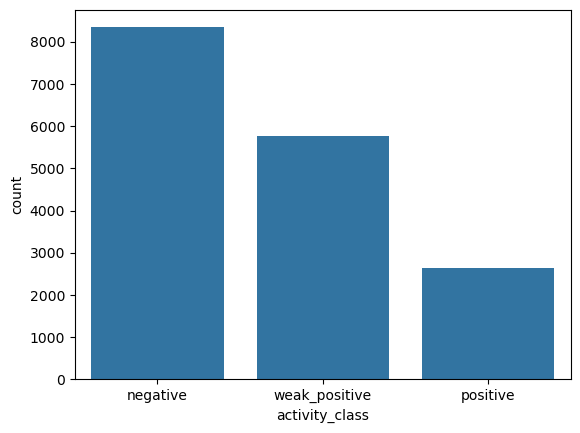

In [42]:
sns.countplot(data=combined, x="activity_class")

<Axes: xlabel='activity_class', ylabel='count'>

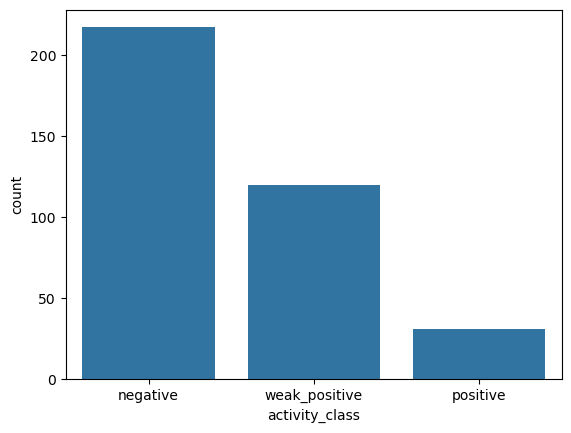

In [43]:
sns.countplot(data=test, x="activity_class")

<Axes: xlabel='activity_class', ylabel='count'>

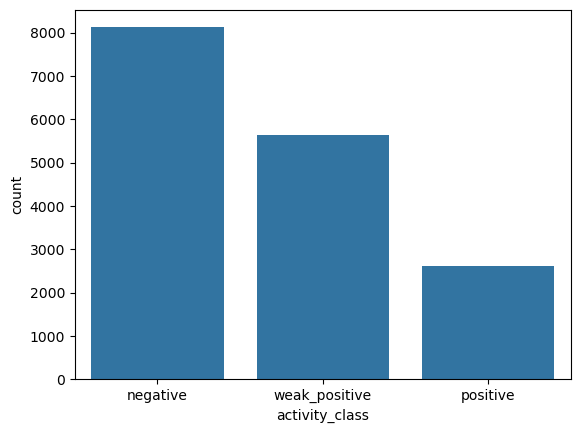

In [44]:
sns.countplot(data=train_data_only, x="activity_class")

In [45]:
combined.to_csv("processed/novartis_2024_combined.csv", index=False)

In [46]:
train_data_only.to_csv("processed/novartis_2024_surrogate_train.csv", index=False)

In [47]:
test.to_csv("processed/novartis_2024_test.csv", index=False)

In [48]:
mols2grid.display(test)

MolGridWidget()